In [1]:
import gc
import os
import sys
import numpy as np
import random
import pandas as pd
from tqdm.notebook import tqdm
import math
import torch
import transformers
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda.amp import GradScaler, autocast
from accelerate import Accelerator
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AutoModel,
    AutoTokenizer,
    AdamW,
    get_linear_schedule_with_warmup,
)
from transformers import AutoConfig

os.environ["TOKENIZERS_PARALLELISM"] = "false"
import warnings

warnings.simplefilter("ignore")

In [2]:
torch.__version__

'2.1.2'

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else "cpu"

In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [5]:
model_ckpt = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
config = AutoConfig.from_pretrained(model_ckpt)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [6]:
EPOCHS = 5
lr = 1e-3
SEED = 42
MAX_LEN = 128
BATCH_SIZE = 64
accumulation_steps = 2
seed_everything(SEED)

**Data Source**

from datasets import load_dataset


clinc = load_dataset("clinc_oos", "plus")

In [7]:
data_path = "../input/data-for-distilation"
train = pd.read_csv("../input/data-for-distilation/Clinc_Train.csv")
valid = pd.read_csv("../input/data-for-distilation/Clinc_valid.csv")
n_classes = np.unique(train.Target).shape[0]
train.head(2)

,Text,Target,intent
0,what expression would i use to say i love you ...,61,translate
1,can you tell me how to say 'i do not speak muc...,61,translate


In [8]:
train.Target.nunique()

151

In [9]:
!pip install einops

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 2.6 MB/s eta 0:00:00


In [10]:
import torch
import torch.nn as nn
from einops import rearrange, reduce, repeat
from typing import Optional, Tuple


def repeat_kv(hidden_states: torch.Tensor, n_rep: int) -> torch.Tensor:
    """
    This is the equivalent of torch.repeat_interleave(x, dim=1, repeats=n_rep). The hidden states go from (batch,
    num_key_value_heads, seqlen, head_dim) to (batch, num_attention_heads, seqlen, head_dim)
    """
    batch, num_key_value_heads, slen, head_dim = hidden_states.shape
    if n_rep == 1:
        return hidden_states
    hidden_states = hidden_states[:, :, None, :, :].expand(
        batch, num_key_value_heads, n_rep, slen, head_dim
    )
    return hidden_states.reshape(batch, num_key_value_heads * n_rep, slen, head_dim)


def repeat_kv_einops(hidden_states: torch.Tensor, n_rep: int) -> torch.Tensor:
    """
    This is the equivalent of torch.repeat_interleave(x, dim=1, repeats=n_rep). The hidden states go from (batch,
    num_key_value_heads, seqlen, head_dim) to (batch, num_attention_heads, seqlen, head_dim)
    """
    batch, num_key_value_heads, slen, head_dim = hidden_states.shape
    if n_rep == 1:
        return hidden_states
    hidden_states = repeat(
        hidden_states,
        "batch num_key_value_heads slen head_dim -> batch num_key_value_heads n_rep slen head_dim",
        n_rep=n_rep,
    )  # hidden_states[:, :, None, :, :].expand(batch, num_key_value_heads, n_rep, slen, head_dim)
    # return hidden_states.reshape(batch, num_key_value_heads * n_rep, slen, head_dim)
    return rearrange(
        hidden_states,
        "batch num_key_value_heads n_rep slen head_dim -> batch (num_key_value_heads n_rep) slen head_dim",
    )


class EncoderAttention(nn.Module):
    def __init__(self, config, layer_idx: int) -> None:
        super().__init__()
        if config.hidden_size % config.num_attention_heads != 0:
            raise ValueError(
                f"The hidden size ({config.hidden_size}) is not a multiple of the number of attention "
                f"heads ({config.num_attention_heads})"
            )
        self.head_size = int(config.hidden_size // config.num_attention_heads)
        self.attention_bias = getattr(config, "attention_bias", True)
        self.layer_idx = layer_idx
        # self.qkv = nn.Linear(config.hidden_size,3*config.hidden_size)
        self.q = nn.Linear(
            config.hidden_size, config.hidden_size, bias=self.attention_bias
        )
        self.k = nn.Linear(
            config.hidden_size, config.hidden_size, bias=self.attention_bias
        )
        self.v = nn.Linear(
            config.hidden_size, config.hidden_size, bias=self.attention_bias
        )
        self.out = nn.Linear(
            config.hidden_size, config.hidden_size, bias=self.attention_bias
        )
        self.num_attention_heads = config.num_attention_heads

    def forward(
        self,
        hidden_state: torch.Tensor,
        attention_mask: torch.Tensor,
        freqs: Optional[torch.Tensor] = None,
    ) -> torch.Tensor:
        q = self.q(hidden_state)
        k = self.k(hidden_state)
        v = self.v(hidden_state)
        # q,k,v = self.qkv(hidden_state).chunk(3, dim = -1) #b X l X d dim =-1 or 2
        # place holder for RoPe operation
        q = rearrange(q, "b l (h d) -> b h l d", h=self.num_attention_heads)
        k = rearrange(k, "b l (h d) -> b h l d", h=self.num_attention_heads)
        v = rearrange(v, "b l (h d) -> b h l d", h=self.num_attention_heads)
        if freqs is not None:
            q, k = apply_rotary_pos_emb(q, k, freqs)

        out = torch.nn.functional.scaled_dot_product_attention(
            query=q, key=k, value=v, attn_mask=attention_mask, is_causal=False
        )
        out = rearrange(out, "b h l d -> b l (h d)")
        out = self.out(out)
        return out


class EncoderAttentionGqa(nn.Module):
    def __init__(self, config, layer_idx: int) -> None:
        super().__init__()
        if config.hidden_size % config.num_attention_heads != 0:
            raise ValueError(
                f"The hidden size ({config.hidden_size}) is not a multiple of the number of attention "
                f"heads ({config.num_attention_heads})"
            )
        self.flash = hasattr(torch.nn.functional, "scaled_dot_product_attention")
        if not self.flash and self.layer_idx == 0:  # avoid to print m times
            print("WARNING: Flash Attention requires PyTorch >= 2.0")
        self.layer_idx = layer_idx
        self.head_dim = int(config.hidden_size // config.num_attention_heads)
        self.num_attention_heads = config.num_attention_heads
        self.num_key_value_heads = getattr(config, "num_key_value_heads", 4)
        self.num_key_value_groups = self.num_attention_heads // self.num_key_value_heads
        if (
            self.num_attention_heads % self.num_key_value_heads != 0
            or self.num_attention_heads < self.num_key_value_heads
        ):
            raise ValueError(
                f"num_key_value_heads {self.num_key_value_heads }  should be less than equal num_attention_heads {config.num_attention_heads} and  multiple of num_attention_heads {config.num_attention_heads} "
            )
        self.attention_bias = getattr(config, "attention_bias", True)
        self.out = nn.Linear(
            config.hidden_size, config.hidden_size, bias=self.attention_bias
        )
        self.q = nn.Linear(
            config.hidden_size, config.hidden_size, bias=self.attention_bias
        )
        self.k = nn.Linear(
            config.hidden_size,
            self.num_key_value_heads * self.head_dim,
            bias=self.attention_bias,
        )
        self.v = nn.Linear(
            config.hidden_size,
            self.num_key_value_heads * self.head_dim,
            bias=self.attention_bias,
        )

    def forward(
        self,
        hidden_state: torch.Tensor,
        attention_mask: torch.Tensor,
        freqs: Optional[torch.Tensor] = None,
    ) -> torch.Tensor:
        q = self.q(hidden_state)
        k = self.k(hidden_state)
        v = self.v(hidden_state)
        q = rearrange(q, "b l (h d) -> b h l d", d=self.head_dim)
        k = rearrange(k, "b l (h d) -> b h l d", d=self.head_dim)
        v = rearrange(v, "b l (h d) -> b h l d", d=self.head_dim)

        if freqs is not None:
            q, k = apply_rotary_pos_emb(q, k, freqs)

        k = repeat_kv(k, n_rep=self.num_key_value_groups)
        v = repeat_kv(v, n_rep=self.num_key_value_groups)
        out = torch.nn.functional.scaled_dot_product_attention(
            query=q, key=k, value=v, attn_mask=attention_mask, is_causal=False
        )

In [11]:
import torch
import torch.nn as nn
from einops import rearrange, reduce
from typing import Optional, Tuple


class AbsoluteEncoding(nn.Module):
    def __init__(self, config) -> None:
        super().__init__()
        self.pos_embeddings = nn.Embedding(
            config.max_position_embeddings, config.hidden_size
        )
        self.register_buffer(
            "position_ids",
            torch.arange(config.max_position_embeddings).expand((1, -1)),
            persistent=False,
        )
        self.max_size = config.max_position_embeddings

    def forward(self, size: int) -> torch.Tensor:
        if self.max_size < size:
            raise ValueError(
                f"The hidden size ({size }) is more than the config max_position_embeddings {self.max_size}"
            )
        return self.pos_embeddings(self.position_ids[:, :size])


class SinusoidalEncoding(nn.Module):
    def __init__(self, config) -> None:
        super().__init__()
        if config.hidden_size % 2 != 0:
            raise ValueError(
                f"Cannot use SinusoidalEncoding with "
                "odd hidden dim got dim {config.hidden_size}"
            )
        self.positional_encoding = torch.zeros(
            1, config.max_position_embeddings, config.hidden_size
        )
        self.position = torch.arange(0, config.max_position_embeddings).unsqueeze(1)
        self.div_term = torch.exp(
            (
                torch.arange(0, config.hidden_size, 2, dtype=torch.float)
                * -(torch.log(torch.tensor(10000.0)) / config.hidden_size)
            )
        )

        self.positional_encoding[:, :, 0::2] = torch.sin(
            self.position.float() * self.div_term
        )
        self.positional_encoding[:, :, 1::2] = torch.cos(
            self.position.float() * self.div_term
        )

    def forward(self, seq_len: int) -> torch.Tensor:

        return self.positional_encoding[:, :seq_len]


# copied from transformer/models/gemma
class RotaryEmbedding(nn.Module):
    def __init__(self, config, base=10000, device=None):
        super().__init__()

        self.dim = int(config.hidden_size // config.num_attention_heads)
        self.max_position_embeddings = config.max_position_embeddings
        self.base = base
        self.register_buffer(
            "inv_freq",
            1.0
            / (
                self.base
                ** (torch.arange(0, self.dim, 2, dtype=torch.int64).float() / self.dim)
            ),
            persistent=False,
        )
        self.register_buffer(
            "position_ids",
            torch.arange(config.max_position_embeddings).expand((1, -1)),
            persistent=False,
        )

    @torch.no_grad()
    def forward(self, seq_len: int = None):
        # x: [bs, num_attention_heads, seq_len, head_size]
        # size = x.size()[2]
        position_ids = torch.arange(seq_len).unsqueeze(0)
        # position_ids = self.position_ids[:, :size].float()

        inv_freq_expanded = (
            self.inv_freq[None, :, None].float().expand(position_ids.shape[0], -1, 1)
        )
        position_ids_expanded = position_ids[:, None, :].float()

        freqs = (inv_freq_expanded.float() @ position_ids_expanded.float()).transpose(
            1, 2
        )
        return freqs


# Copied from transformers.models.llama.modeling_llama.rotate_half
def rotate_half(x):
    """Rotates half the hidden dims of the input."""
    x1 = x[..., : x.shape[-1] // 2]
    x2 = x[..., x.shape[-1] // 2 :]
    return torch.cat((-x2, x1), dim=-1)


# def rotate_half(x):
#     x1, x2 = x.chunk(2, dim=-1)
#     return torch.cat((-x2, x1), dim=-1)


# Copied from transformers.models.llama.modeling_llama.apply_rotary_pos_emb
def apply_rotary_pos_emb(
    q, k, freqs, only_q: bool = False, unsqueeze_dim=1
) -> Tuple[torch.Tensor]:
    """Applies Rotary Position Embedding to the query and key tensors.

    Args:
        q (`torch.Tensor`): The query tensor.
        k (`torch.Tensor`): The key tensor.
        freqs: precalculated frqs for sin cos
        only_q: bool = False for encoder decoder
        unsqueeze_dim (`int`, *optional*, defaults to 1):
            The 'unsqueeze_dim' argument specifies the dimension along which to unsqueeze cos[position_ids] and
            sin[position_ids] so that they can be properly broadcasted to the dimensions of q and k. For example, note
            that cos[position_ids] and sin[position_ids] have the shape [batch_size, seq_len, head_dim]. Then, if q and
            k have the shape [batch_size, heads, seq_len, head_dim], then setting unsqueeze_dim=1 makes
            cos[position_ids] and sin[position_ids] broadcastable to the shapes of q and k. Similarly, if q and k have
            the shape [batch_size, seq_len, heads, head_dim], then set unsqueeze_dim=2.
    Returns:
        `tuple(torch.Tensor)` comprising of the query and key tensors rotated using the Rotary Position Embedding.
    """
    emb = torch.cat((freqs, freqs), dim=-1)
    cos = emb.cos()
    sin = emb.sin()
    cos = cos.unsqueeze(unsqueeze_dim)
    sin = sin.unsqueeze(unsqueeze_dim)
    #     print(cos.size(),sin.size(),q.size(),k.size())
    if only_q:
        q_embed = (q * cos) + (rotate_half(q) * sin)
    else:

        q_embed = (q * cos) + (rotate_half(q) * sin)
        k_embed = (k * cos) + (rotate_half(k) * sin)
        return q_embed, k_embed


# To do :  Alibi

In [12]:
import torch
import torch.nn as nn
from einops import rearrange, reduce
from typing import Optional, Tuple, Union

_ACT_ = {
    "gelu": nn.GELU(),
    "leaky_relu": nn.LeakyReLU(),
    "relu6": nn.ReLU6(),
    "sigmoid": nn.Sigmoid(),
    "silu": nn.SiLU(),
    "swish": nn.SiLU(),
    "tanh": nn.Tanh(),
}


class FeedForward(nn.Module):
    def __init__(self, config, multiplier: Union[int, float] = 4) -> None:
        super().__init__()
        self.intermediate = nn.Linear(
            config.hidden_size, int(multiplier) * config.hidden_size
        )
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.layerNorm = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)
        if _ACT_.get(getattr(config, "hidden_act", None), None):
            self.act_fn = _ACT_[config.hidden_act]
        else:
            self.act_fn = nn.GELU()
        self.out = nn.Linear(int(multiplier) * config.hidden_size, config.hidden_size)

    def forward(
        self, hidden_state: torch.Tensor, input_tensor: torch.Tensor
    ) -> torch.Tensor:
        output = self.intermediate(hidden_state)
        output = self.act_fn(output)
        output = self.out(output)
        output = self.dropout(output)
        output = self.layerNorm(output + input_tensor)
        return output

In [13]:
import torch
import torch.nn as nn
from typing import Optional, Tuple

from dataclasses import dataclass

_position_embeddings = {
    "absolute": AbsoluteEncoding,
    "sinusoidal": SinusoidalEncoding,
}  #'relative':RelativePositionalEncoding


@dataclass
class EncoderOutput(object):
    logits: torch.Tensor


@dataclass
class MLMOutput(object):
    hidden_state: torch.Tensor
    logits: torch.Tensor


class EncoderLayer(nn.Module):
    def __init__(self, config, layer_idx: int, attention_type: str = None) -> None:
        super().__init__()
        self.attention = (
            EncoderAttentionGqa(config, layer_idx=layer_idx)
            if attention_type == "gqa"
            else EncoderAttention(config, layer_idx=layer_idx)
        )
        if attention_type == "gqa" and layer_idx == 0:  # avoid to print m times
            print("Encoder Using GQA Attention")
        self.feed_forward = FeedForward(config)
        self.layer_idx = layer_idx

    def forward(
        self,
        hidden_state: torch.Tensor,
        attention_mask: torch.Tensor,
        freqs: torch.Tensor = None,
    ) -> torch.Tensor:
        out = self.attention(
            hidden_state=hidden_state, attention_mask=attention_mask, freqs=freqs
        )
        out = self.feed_forward(out, hidden_state)
        return out


class LMHead(nn.Module):
    """Head for masked language modelling"""

    def __init__(self, config) -> None:
        super().__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.layer_norm = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)

        self.decoder = nn.Linear(config.hidden_size, config.vocab_size)
        self.bias = nn.Parameter(torch.zeros(config.vocab_size))
        self.decoder.bias = self.bias

    def forward(self, hidden_state: torch.Tensor) -> torch.Tensor:
        x = self.dense(hidden_state)
        x = nn.GELU()(x)
        x = self.layer_norm(x)

        # project back to size of vocabulary with bias
        x = self.decoder(x)

        return x


class EncoderModel(nn.Module):

    def __init__(
        self,
        config,
        pos_embedding_type: Optional[str] = "absolute",
        attention_type: str = None,
    ) -> None:
        super().__init__()
        self.word_embeddings = nn.Embedding(
            config.vocab_size,
            config.hidden_size,
            padding_idx=getattr(config, "pad_token_id", None),
        )
        if _position_embeddings.get(pos_embedding_type, None) is not None:
            self.position_embeddings = _position_embeddings.get(pos_embedding_type)(
                config
            )
        else:
            self.position_embeddings = None
        if pos_embedding_type == "rope":
            self.emb_freq = RotaryEmbedding(config)(config.max_position_embeddings)
            print(
                "Encoder Ignoring sinusoidal or absolute position embeddings because rope,is enable"
            )
        self.all_layer = nn.ModuleList(
            [
                EncoderLayer(config, layer_idx, attention_type)
                for layer_idx in range(config.num_hidden_layers)
            ]
        )

    def forward(
        self, input_ids: torch.Tensor, attention_mask: torch.Tensor
    ) -> torch.Tensor:
        bsz, seqlen = input_ids.shape
        hidden_state = self.word_embeddings(input_ids)
        freqs = None
        if self.position_embeddings is not None:
            pos_info = self.position_embeddings(seqlen)[:, :seqlen, :].to(
                input_ids.device
            )
            hidden_state = hidden_state + pos_info
        else:
            freqs = self.emb_freq[:, :seqlen].to(input_ids.device)

        attention_mask = attention_mask.unsqueeze(1).unsqueeze(2).type_as(hidden_state)
        attention_mask = (1.0 - attention_mask) * torch.finfo(hidden_state.dtype).min

        for layer in self.all_layer:
            hidden_state = layer(hidden_state, attention_mask, freqs)
        return EncoderOutput(hidden_state)

    @classmethod
    def from_config(
        cls,
        config,
        pos_embedding_type: Optional[str] = "absolute",
        attention_type: str = None,
    ) -> nn.Module:
        return cls(config, pos_embedding_type, attention_type)

In [14]:
config

RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.39.3",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

In [15]:
config.num_hidden_layers = 6
model = EncoderModel(config)

In [16]:
model

EncoderModel(
  (word_embeddings): Embedding(50265, 768, padding_idx=1)
  (position_embeddings): AbsoluteEncoding(
    (pos_embeddings): Embedding(514, 768)
  )
  (all_layer): ModuleList(
    (0-5): 6 x EncoderLayer(
      (attention): EncoderAttention(
        (q): Linear(in_features=768, out_features=768, bias=True)
        (k): Linear(in_features=768, out_features=768, bias=True)
        (v): Linear(in_features=768, out_features=768, bias=True)
        (out): Linear(in_features=768, out_features=768, bias=True)
      )
      (feed_forward): FeedForward(
        (intermediate): Linear(in_features=768, out_features=3072, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (layerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (act_fn): GELU(approximate='none')
        (out): Linear(in_features=3072, out_features=768, bias=True)
      )
    )
  )
)

In [18]:
class ClinicModel(nn.Module):
    def __init__(self, config, model):
        super(ClinicModel, self).__init__()
        self.model = model
        self.output = nn.Linear(768, n_classes)

    def forward(self, ids, mask):
        sequence_output = self.model(ids, mask).logits[:, 0, :]
        #         sequence_output = sequence_output[:, 0, :]
        logits = self.output(sequence_output)
        return logits

In [19]:
train_texts = train["Text"].values.tolist()
val_texts = valid["Text"].values.tolist()
train_labels = train["Target"].values.tolist()
val_labels = valid["Target"].values.tolist()
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=128)


class ClinicDatasetV2(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return {
            "ids": item.get("input_ids"),
            "mask": item.get("attention_mask"),
            "labels": item.get("labels"),
        }

    def __len__(self):
        return len(self.labels)


train_loader = torch.utils.data.DataLoader(
    ClinicDatasetV2(train_encodings, train_labels),
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
)
val_loader = torch.utils.data.DataLoader(
    ClinicDatasetV2(val_encodings, val_labels),
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
)

In [20]:
def valid_func(model, val_loader, val_bar):
    model.eval()
    #     bar = tqdm(valid_loader,file=sys.stdout)
    loss_fn = torch.nn.CrossEntropyLoss()
    PROB = []
    TARGETS = []
    losses = []
    PREDS = []

    for batch_idx, data in enumerate(val_loader):
        val_bar.update(1)
        input_ids = data["ids"].cuda()
        input_masks = data["mask"].cuda()
        targets = data["labels"].long().view(-1).cuda()
        with torch.no_grad():
            logits = model(input_ids, input_masks)

        PREDS += [torch.argmax(logits, 1).detach().cpu()]
        TARGETS += [targets.detach().cpu()]

        loss = loss_fn(logits, targets)
        losses.append(loss.item())
        val_bar.set_description(f'step: {batch_idx+1} loss: {"%.4f" % loss}')

    PREDS = torch.cat(PREDS).cpu().numpy()
    TARGETS = torch.cat(TARGETS).cpu().numpy()
    accuracy = (PREDS == TARGETS).mean()

    loss_valid = np.mean(losses)
    return loss_valid, accuracy

In [21]:
def single_gpu(name):
    use_amp = True
    debug = False
    gc.collect()
    best_epoch_loss = np.inf

    net = ClinicModel(config, model)
    net.cuda()
    log_df = pd.DataFrame(
        columns=["Epoch", "Train_Loss", "Valid_Loss", "Valid_Accuracy"]
    )
    accelerator = Accelerator(
        log_with="tensorboard", project_dir=".", mixed_precision="fp16"
    )
    #     accelerator = Accelerator(mixed_precision='bf16')
    Config = {
        "num_epoch": EPOCHS,
        "learning_rate": lr,
        "loss_function": str(torch.nn.CrossEntropyLoss),
    }

    accelerator.init_trackers(f"{name}_project", config=Config)

    loss_fn = torch.nn.CrossEntropyLoss()
    optimizer = AdamW(net.parameters(), lr=lr)
    num_train_optimization_steps = int(EPOCHS * len(train_loader) / accumulation_steps)
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0.05 * num_train_optimization_steps,
        num_training_steps=num_train_optimization_steps,
    )  # PyTorch scheduler
    if use_amp:
        scaler = torch.cuda.amp.GradScaler()
    epoch_check = len(train_loader)
    total_step = epoch_check * EPOCHS
    train_bar = tqdm(total=total_step, dynamic_ncols=True)
    val_bar = tqdm(total=len(val_loader), leave=True, dynamic_ncols=True)
    t_step = 1
    for epoch in range(5):
        avg_loss = 0.0
        net.train()
        loss_list = []
        for step, data in enumerate(train_loader):
            train_bar.update(1)
            #         train_bar.set_description(f"step: {i+1} epoch: {epoch+1}")
            input_ids = data["ids"].cuda()
            input_masks = data["mask"].cuda()
            targets = data["labels"].long().view(-1).cuda()
            with torch.cuda.amp.autocast():
                pred = net(input_ids, input_masks)
            loss = loss_fn(pred, targets)
            scaler.scale(loss).backward()
            if step % accumulation_steps == 0:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()
            accelerator.log({"training_loss_step": loss}, step=t_step)
            t_step += 1

            loss_list.append(loss.detach().cpu().item())
        scheduler.step()
        avg_loss = np.round(np.mean(loss_list), 4)
        accelerator.log({"train_epoch": avg_loss}, step=epoch)
        vloss, vaccuracy = valid_func(net, val_loader, val_bar)
        accelerator.log({"vloss_epoch": loss}, step=epoch)
        accelerator.log({"vaccuracy_epoch": vaccuracy}, step=epoch)
        print(f'Epoc: {epoch} loss: {"%.4f" % vloss},accuracy: {"%.4f" % vaccuracy}')
        val_bar.reset()
    accelerator.end_training()

In [22]:
 single_gpu(name = 'absolute_embedding')

2024-04-29 08:33:04.992409: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-29 08:33:04.992533: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-29 08:33:05.113146: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


  0%|          | 0/1195 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

Epoc: 0 loss: 5.1766,accuracy: 0.0061
Epoc: 1 loss: 2.0515,accuracy: 0.5268
Epoc: 2 loss: 0.7607,accuracy: 0.8184
Epoc: 3 loss: 0.6425,accuracy: 0.8494
Epoc: 4 loss: 0.6074,accuracy: 0.8581


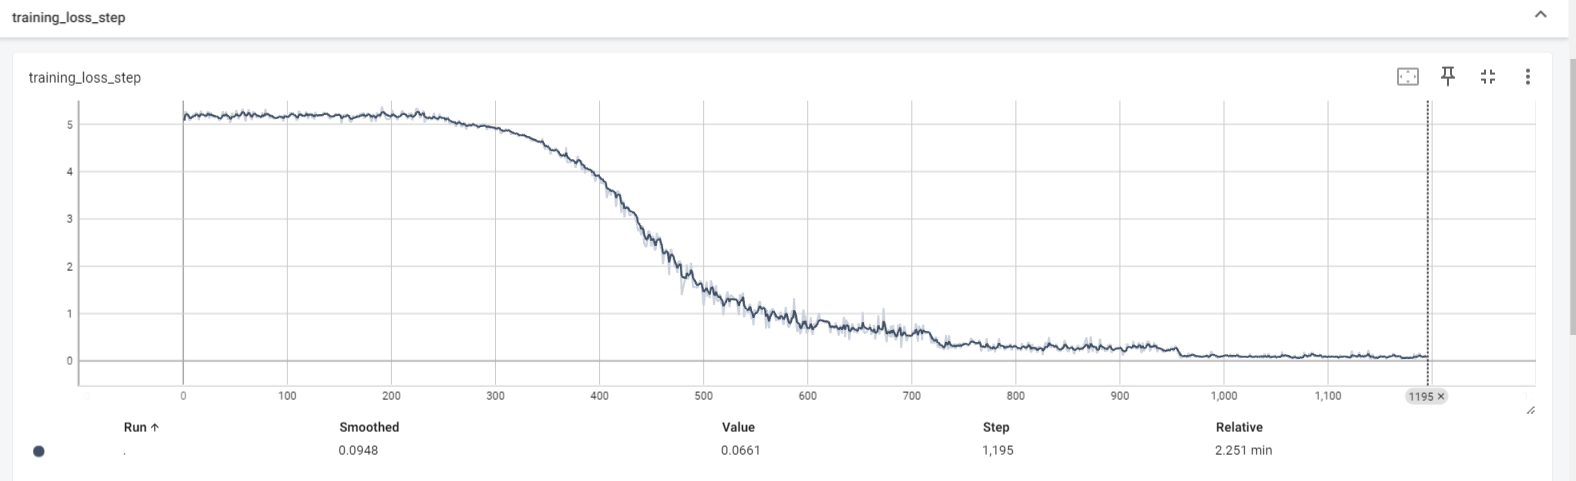

In [2]:
from PIL import Image

Image.open("../input/vyom-ai-images/Absolute.png").convert("RGB")

In [23]:
model = EncoderModel(config, pos_embedding_type="rope")

Encoder Ignoring sinusoidal or absolute position embeddings because rope,is enable


In [24]:
single_gpu(name="RoPE")

  0%|          | 0/1195 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

Epoc: 0 loss: 5.1949,accuracy: 0.0081
Epoc: 1 loss: 1.3297,accuracy: 0.6874
Epoc: 2 loss: 0.6135,accuracy: 0.8471
Epoc: 3 loss: 0.5565,accuracy: 0.8619
Epoc: 4 loss: 0.5512,accuracy: 0.8671


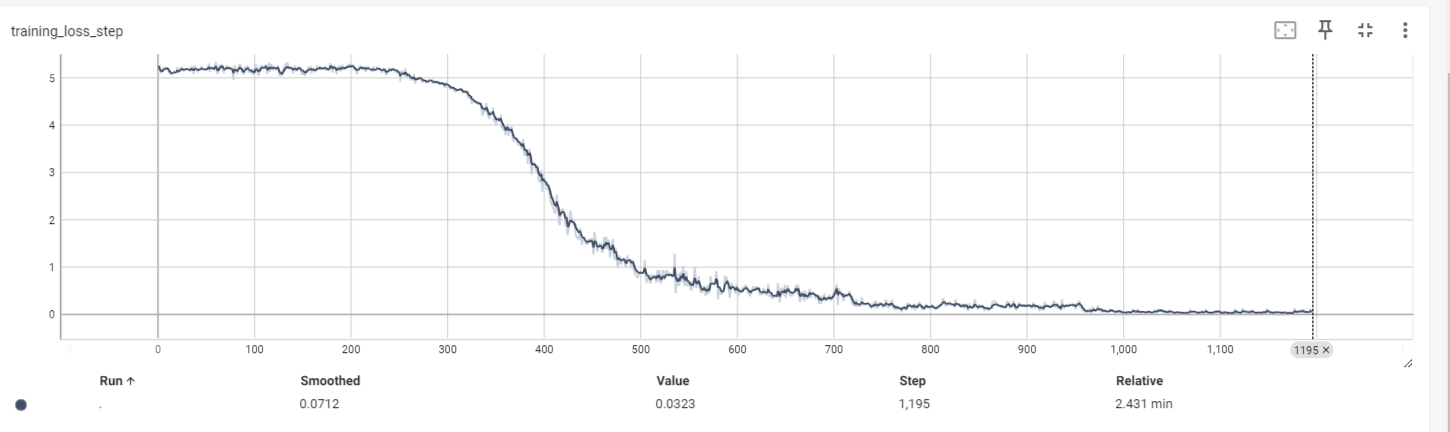

In [3]:
from PIL import Image

Image.open("../input/vyom-ai-images/RoPE.png").convert("RGB")